In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('D:/KLTN/STOCK-PREDICTION/data/MWG.csv')
data

,Unnamed: 0,time,open,high,low,close,volume
0,0,2018-01-02,30.47,30.82,30.47,30.70,566400
1,1,2018-01-03,30.75,31.45,30.70,31.31,1132510
2,2,2018-01-04,31.19,31.49,31.17,31.38,678710
3,3,2018-01-05,31.40,31.40,30.89,31.03,733030
4,4,2018-01-08,30.82,30.94,30.47,30.54,752020
...,...,...,...,...,...,...,...
1745,1745,2024-12-25,61.30,62.30,61.30,62.20,6300500
1746,1746,2024-12-26,62.40,62.40,60.50,61.50,6554700
1747,1747,2024-12-27,60.60,61.60,60.40,61.40,6947200
1748,1748,2024-12-30,60.50,61.20,60.50,61.00,4178100


In [3]:
def process_data_arima(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    # Lấy chuỗi thời gian giá 'close'
    data = np.log(data['close'])

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    train, test = train_test_split(data, test_size=0.2, shuffle=False)

    return train, test

In [4]:
train, test = process_data_arima(data)

In [14]:
print(train.shape)  # In ra kích thước của x_train
print(test.shape)   # In ra kích thước của x_test

(1408,)
(353,)


In [3]:
#Kiểm tra dữ liệu đã dừng hay chưa

def check_stationarity(data):
    result = adfuller(data)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("Chuỗi dữ liệu đã dừng (p < 0.05)")
    else:
        print(" Chuỗi dữ liệu chưa dừng (p >= 0.05), Cần sai phân")

# Kiểm tra tính dừng của dữ liệu
check_stationarity(data['close'].values)


ADF Statistic: -1.178174140778674
p-value: 0.6829134808969003
 Chuỗi dữ liệu chưa dừng (p >= 0.05), Cần sai phân


In [4]:
#thực hiện sai phân bậc 1

# Sai phân bậc 1
data['close_diff1'] = data['close'].diff().dropna()

# Kiểm tra lại tính dừng sau khi sai phân
check_stationarity(data['close_diff1'].dropna().values)

ADF Statistic: -26.049097399368385
p-value: 0.0
Chuỗi dữ liệu đã dừng (p < 0.05)


In [6]:
def arima_model(train_series):
    
    model = auto_arima(train_series,
                       start_p=0, start_q=0,
                       test='adf',               # Kiểm tra tính dừng bằng Augmented Dickey-Fuller
                       max_p=5, max_q=5,
                       d=None,                  # Để auto_arima tự chọn bậc d
                       seasonal=False,          # Không dùng yếu tố mùa vụ
                       start_P=0,
                       D=0,
                       trace=True,              # Hiển thị quá trình lựa chọn mô hình
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

    print(model.summary())
    return model


In [7]:
# Dự đoán
fit = arima_model(train)

forecast = fit.predict(n_periods=len(test))

C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7135.091, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7133.095, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7133.092, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7135.279, Time=0.10 sec


C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7131.091, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.856 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1401
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3568.639
Date:                Mon, 19 May 2025   AIC                          -7135.279
Time:                        22:33:36   BIC                          -7130.035
Sample:                             0   HQIC                         -7133.318
                               - 1401                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   9.47e-06     37.733      0.000       0.000

C:\Users\dinhq\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [173]:
import pickle
with open('model/ARIMA-VCB.pkl', 'wb') as f:
    pickle.dump(fit, f)

In [5]:
import pickle

with open('D:/KLTN/STOCK-PREDICTION/trained/ARIMA-MWG.pkl', 'rb') as f:
    model = pickle.load(f)


In [6]:
forecast = model.predict(n_periods=len(test))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
np.exp(forecast)

1408    330.025338
1409    330.338838
1410    330.652635
1411    330.966731
1412    331.281125
           ...    
1754    458.375073
1755    458.810495
1756    459.246331
1757    459.682581
1758    460.119246
Length: 351, dtype: float64

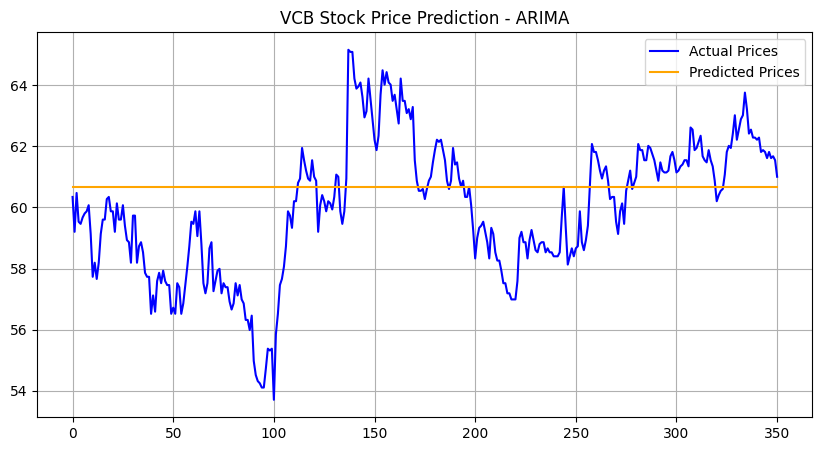

In [51]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [172]:
#Tính toán các chỉ số đánh giá #VCB
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)


RMSE:  0.038879032579705194
MAE:  0.030782312828560913
R-squared:  -0.10762676215206524


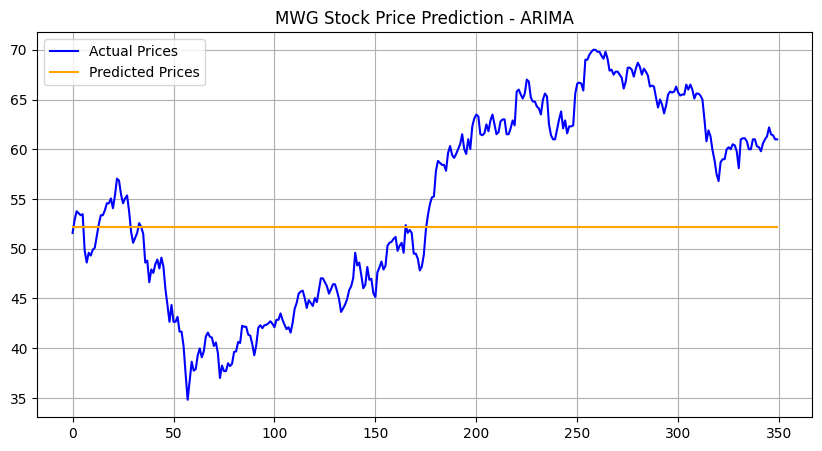

In [7]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [8]:
#Tính toán các chỉ số đánh giá #MWG
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.1853527576419473
MAE:  0.1655155102683946
R-squared:  -0.030462914766268945


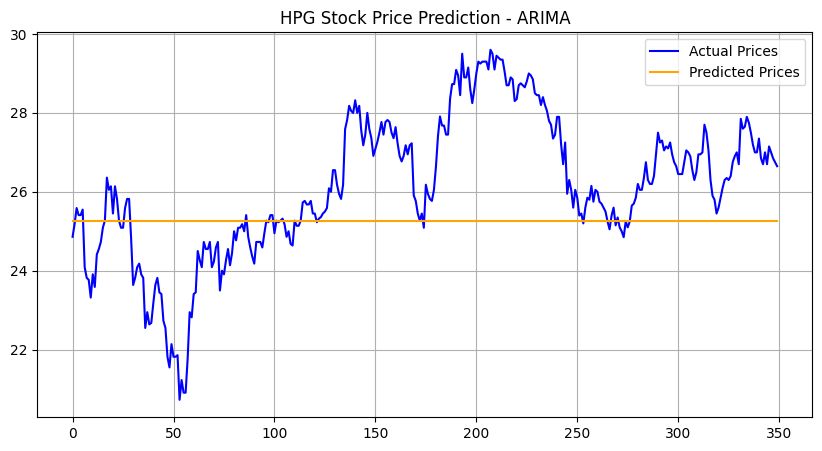

In [45]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [46]:
#Tính toán các chỉ số đánh giá #HPG
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)


RMSE:  0.07633186095958609
MAE:  0.060714872120461935
R-squared:  -0.20316488020294798


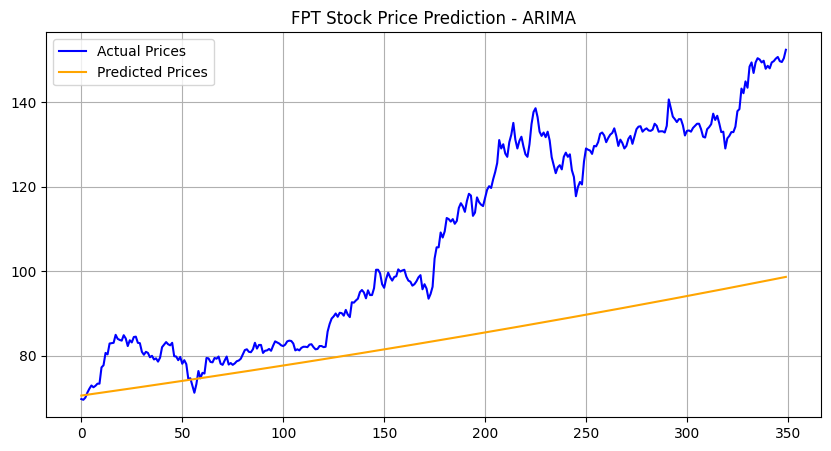

In [39]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [40]:
#Tính toán các chỉ số đánh giá #FPT
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.2694349044163393
MAE:  0.22821453493343288
R-squared:  -0.31602925892038214


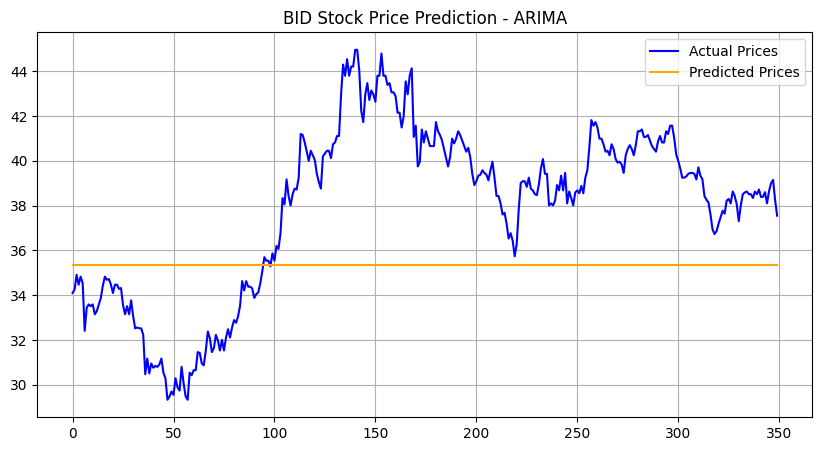

In [34]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [33]:
#Tính toán các chỉ số đánh giá #BID
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)


RMSE:  0.12267121680341171
MAE:  0.11096239572028772
R-squared:  -0.37940602155487513


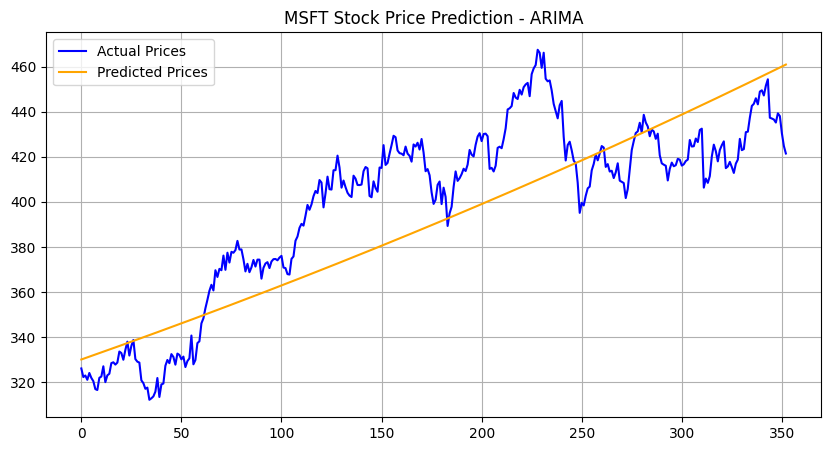

In [28]:
# Vẽ biểu đồ 
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(test)), np.exp(test), label='Actual Prices', color='blue')
plt.plot(np.arange(len(forecast)), np.exp(forecast), label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - ARIMA')
plt.legend()
plt.grid(True)
plt.show()
    

In [150]:
#Tính toán các chỉ số đánh giá #MSFT
rmse = np.sqrt(mean_squared_error(test,forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)


RMSE:  0.0606352948047934
MAE:  0.05248145213104237
R-squared:  0.6593395738456256
